In [227]:
import numpy as np
import pandas as pd
import scipy.stats
import math

# System files 
import sys
import os

#sys.path.append('..')  # now I'm in the parent directory
cwd = os.getcwd()
print(cwd)

# external libraries
from src.cleaning.export_data import *
from src.functions.sectors import *
from src.cleaning.processing import *
from src.visualizing.complex_eigenvectors import *
from src.hpca.hilbert import *
from src.hpca.hpca import *

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
%matplotlib inline

# Set the preset style and context
sns.set_style('ticks')
sns.set_palette('dark')

rcParams['axes.spines.bottom']=True
rcParams['axes.spines.right']=False
rcParams['axes.spines.left']=False
rcParams['axes.spines.top']=False
rcParams['axes.linewidth'] = 2
rcParams['axes.edgecolor'] = 'grey'

rcParams['axes.ymargin'] = 0
rcParams['axes.axisbelow'] = True
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 15
rcParams['legend.loc'] = 'upper right' 

rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = 'grey'

rcParams['xtick.major.width'] = 2
rcParams['xtick.major.size'] = 5
rcParams['xtick.color'] = 'grey'

rcParams['font.size'] = 14
rcParams['font.family'] = 'Arial'
#rcParams['text.color'] = 'grey'
#rcParams['axes.labelcolor'] = 'grey'

rcParams['figure.figsize'] = (10, 10)

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 900
rcParams['savefig.transparent'] = True

# Plot Styles
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 4

/Users/pietrobicocchi/Desktop/hilbert_pca_svd


- clean sales and prices

In [228]:
path_clean_s = os.getcwd() + '/data/cleaned/CompuStat_sales.pkl'
path_clean_p = os.getcwd() + '/data/cleaned/CompuStat_prices.pkl'

# Load the saved DataFrame for RETURNS of Sales and Prices 
sales = pd.DataFrame(load_cleaned_data(path_clean_s)) 
prices = pd.DataFrame(load_cleaned_data(path_clean_p))

- sectorizing the sales and the prices

In [229]:
gvkeys = list(sales.columns)  # list of gvkeys of my sales data
sectors = extract_data(cwd + '/data/raw/CompuStat/sectors.csv') 
key_to_sect = get_unique_sectors(sectors)
key_sect = gvkeys_to_sect(gvkeys, key_to_sect)
idx_by_sector, sector_dict, sector_indices, sector_labels = create_sectors(key_sect)

/Users/pietrobicocchi/Desktop/hilbert_pca_svd/src/functions/sectors.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors["datadate"] = pd.to_datetime(sectors["datadate"])
/Users/pietrobicocchi/Desktop/hilbert_pca_svd/src/functions/sectors.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors['gsector'] = sectors['gsector'].fillna(1)
/Users/pietrobicocchi/Desktop/hilbert_pca_svd/src/functions/sectors.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

- creating 'ad hoc' tailored prices: in order to have match sales and prices data for the same companies.

In [238]:
sales_df, prices_df = raw_to_dataframes(extract_data(os.getcwd() + '/data/raw/CompuStat/crsp_ccm_inventories_sales.csv'))
sales_keys = sales.keys()
tailored_prices = tailored_clean(prices_df, sales_keys)
prices = tailored_prices # the prices we are interested in

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


From now on we will work with:
- Sales (log-returns normalized)
- Prices (log-returns normalized)
for **787 companies** in a time period of **248 quarters** = 62 years

In [239]:
sales.head(10)

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
datadate,,,,,,,,,,,,,,,,,,,,,
1961-06-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1961-09-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1961-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1962-03-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1962-06-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1962-09-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.287553,0.0,0.000000
1962-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.211060,0.0,0.000000
1963-03-31,0.0,0.0,0.0,0.0,-0.155711,0.0,1.415907,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.510730,0.0,0.002523
1963-06-30,0.0,0.0,0.0,0.0,-0.088812,0.0,1.931288,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-2.349871,0.0,-0.025226


In [240]:
prices.head(10)

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
datadate,,,,,,,,,,,,,,,,,,,,,
1961-06-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1961-09-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1961-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1962-03-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1962-06-30,0.0,0.0,0.0,0.0,-3.091180,0.0,-1.175047,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-3.140166,0.0,0.0
1962-09-30,0.0,0.0,0.0,0.0,0.709329,0.0,-0.287283,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.976992,0.0,0.0
1962-12-31,0.0,0.0,0.0,0.0,0.690092,0.0,1.363055,0.0,0.0,0.0,...,0.073211,0.0,0.0,0.0,0.0,0.0,0.0,0.883223,0.0,0.0
1963-03-31,0.0,0.0,0.0,0.0,-0.099118,0.0,0.844746,0.0,0.0,0.0,...,0.219140,0.0,0.0,0.0,0.0,0.0,0.0,-0.868704,0.0,0.0
1963-06-30,0.0,0.0,0.0,0.0,-0.064515,0.0,0.321809,0.0,0.0,0.0,...,0.038327,0.0,0.0,0.0,0.0,0.0,0.0,-0.382195,0.0,0.0


### Hilbert PCA

- analytic signal for the returns
    
<math>\begin{align}
s_\mathrm{a}(t) &= s(t) + j\hat{s}(t)
\end{align}</math>

where $\hat{s}(t)$ is the hilbert transform of the returns

- CPCA on Sales

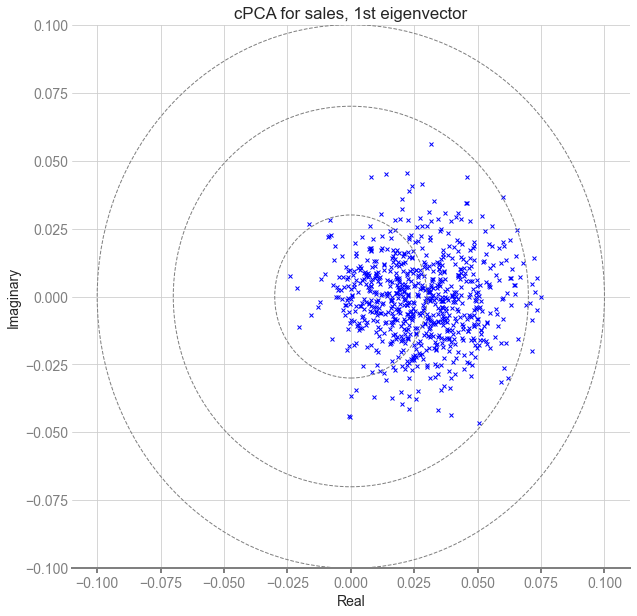

In [241]:
analytic_s = analytic_signal(sales)
corr, eVal, eVec = complex_eigendecomposition(analytic_s)
plotting_complex_plane(eVec[:,0], title = "cPCA for sales, 1st eigenvector", rad1=0.03, rad2=0.07, rad3=0.1)

- cPCA on Prices

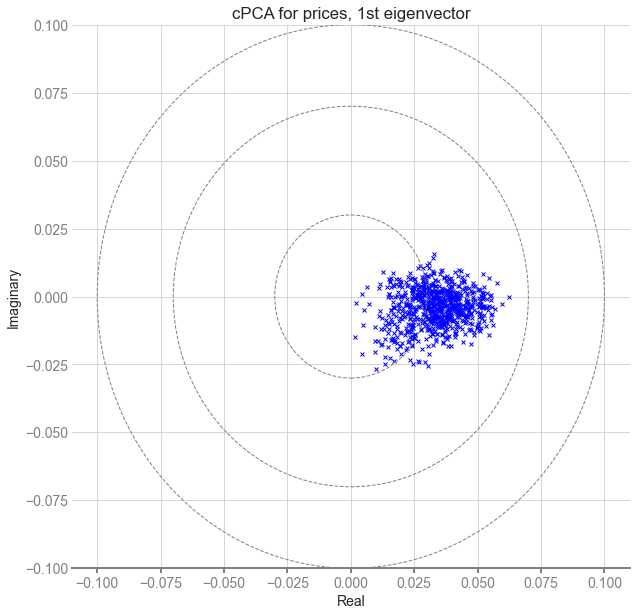

In [175]:
analytic_p = analytic_signal(prices)
corr, eVal, eVec = complex_eigendecomposition(analytic_p)
plotting_complex_plane(eVec[:,0], title = "cPCA for prices, 1st eigenvector", rad1=0.03, rad2=0.07, rad3=0.1)

- cSVD (complex SVD), **prices** leading and **sales** lagging

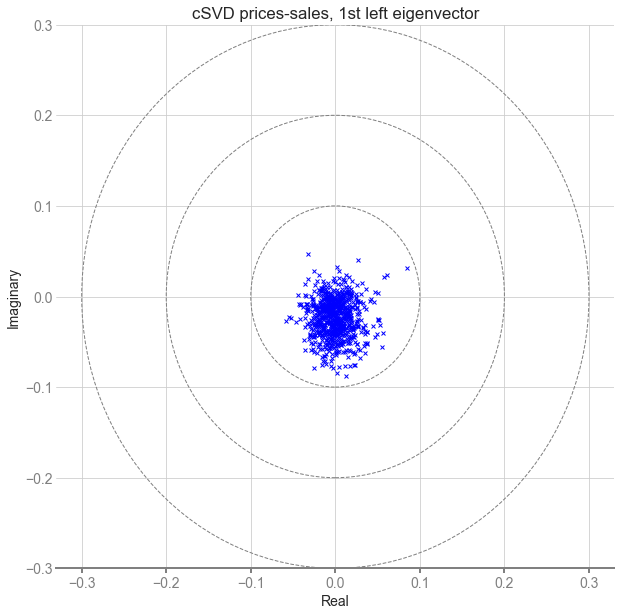

In [33]:
u, s, v = complex_svd(analytic_s, analytic_p)
plotting_complex_plane(u[:,0], title = "cSVD prices-sales, 1st left eigenvector")

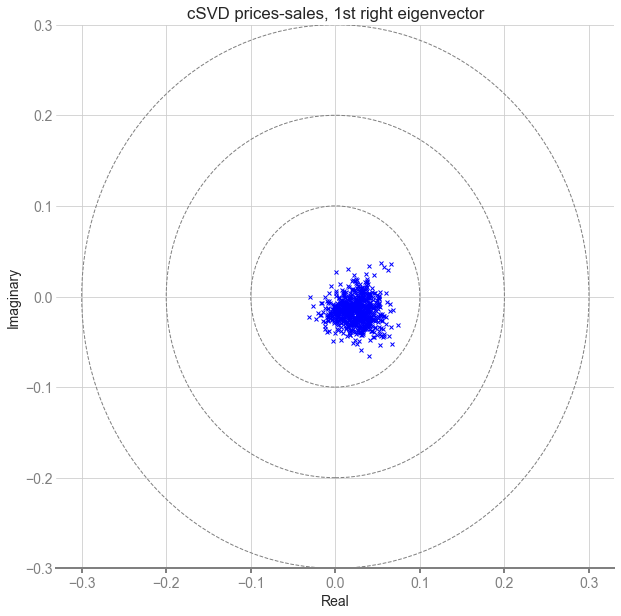

In [34]:
plotting_complex_plane(v.T[:,0], title = "cSVD prices-sales, 1st right eigenvector")

- **Sectors in evidence**

In [35]:
def plotting_sectors_complex_plane(complex_array, sectors):
    sector_colors = {
    'Utilities': 1,
    'Energy': 2,
    'Industrials': 5,
    'Materials': 6,
    'Other': 7,
    'Financials': 10,
    'Health Care': 11,
    'Information Technology': 12,
    'Real Estate': 13,
    'Consumer Staples': 14,
    'Consumer Discretionary': 15,
    'Communication Services': 16
    }

    # Convert the sectors to corresponding colors
    colors = [sector_colors[sector] for sector in sectors]

    # Extract the real and imaginary parts and modulus
    real_part = np.real(complex_array)
    imaginary_part = np.imag(complex_array)
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Plot the complex array
    ax.scatter(real_part, imaginary_part, marker='o', c=colors, cmap='coolwarm')

    # Create a circle patch
    circle1 = Circle((0, 0), radius=0.05, edgecolor='grey', facecolor='none', linewidth=1, linestyle = '--')
    ax.add_patch(circle1)
    
    # Add a color bar to indicate the mapping between colors and sectors
    #cbar = plt.colorbar()
    #cbar.set_label('Sectors')
    
    # Display the plot
    plt.grid(True)
    plt.show()

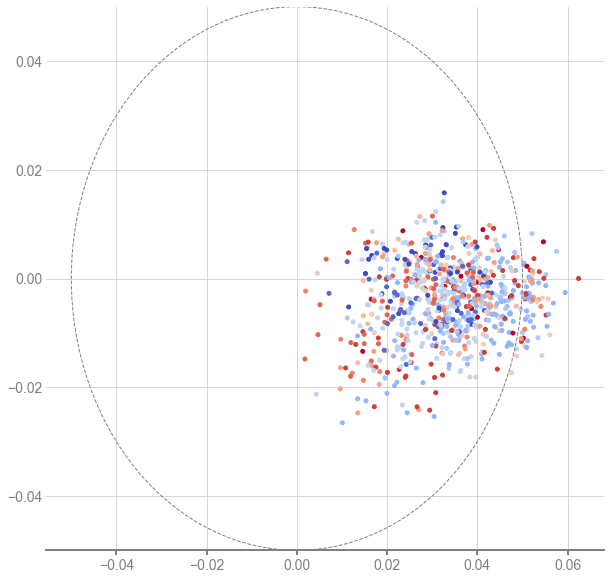

In [36]:
plotting_sectors_complex_plane(eVec[:,0], key_sect)

In [352]:
d = key_to_sect['maj_sector'].to_dict()
el =[]
for key in d.keys():
    if key not in sales.columns:
        el.append(key)


579

In [353]:
sales.columns

Int64Index([ 1004,  1045,  1062,  1072,  1075,  1076,  1078,  1104,  1121,
             1161,
            ...
            11669, 11670, 11672, 11687, 13003, 13714, 14253, 15106, 15247,
            28590],
           dtype='int64', name='GVKEY', length=768)

- **Fourier Analysis of Modes**

polar form of eigenvectors

In [44]:
import cmath

def total_sum(complex_vector):    
    # Compute the polar form of each component
    polar_form = [cmath.polar(c) for c in complex_vector]

    # Extract the magnitude and angle (in radians) from the polar form
    magnitudes = [p[0] for p in polar_form]
    angles = [p[1] for p in polar_form]

    # Compute the sum of the absolute values of the angles
    angle_sum = sum(abs(angle) for angle in angles)
    
    return angle_sum, magnitudes, angles

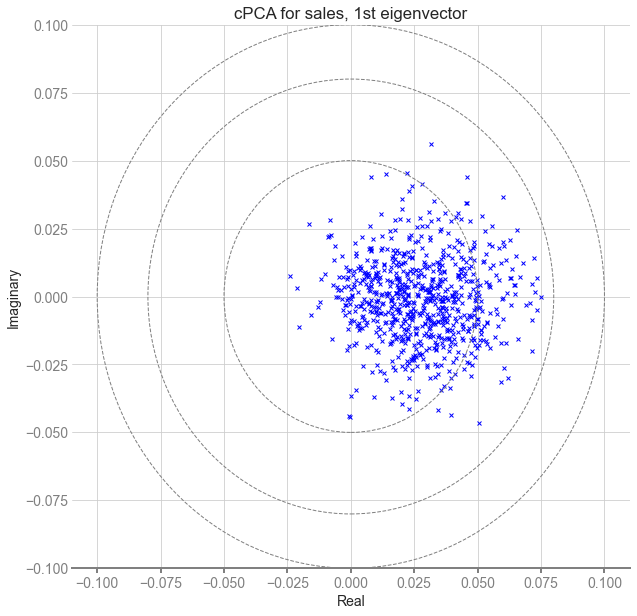

In [53]:
analytic_s = analytic_signal(sales)
corr, eVal, eVec = complex_eigendecomposition(analytic_s)
plotting_complex_plane(eVec[:,0], title = "cPCA for sales, 1st eigenvector", rad1=0.05, rad2=0.08, rad3=0.1)

Text(0.5, 0, 'radiants')

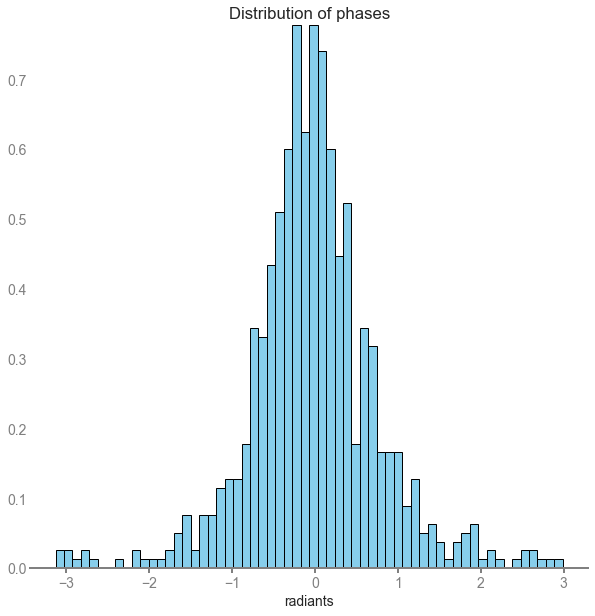

In [109]:
ang_sum, magnitudes, phases = total_sum(eVec[:,0])
plt.hist(phases, bins=60, color='skyblue', edgecolor='black', density=True)
plt.title('Distribution of phases')
plt.xlabel('radiants')

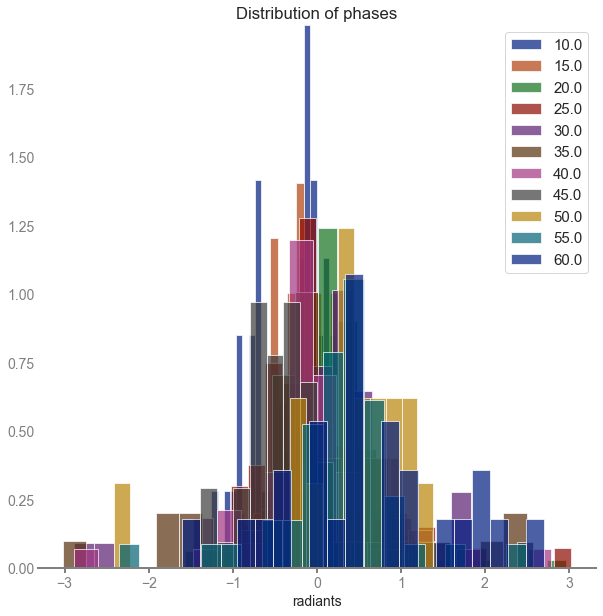

In [315]:
dic = {}
for i in range(np.shape(analytic_s)[1]):
    dic[i] = sales.columns[i]
dic

df = pd.DataFrame(analytic_s).rename(columns=dic)
sectors = key_to_sect['maj_sector'].to_dict()
stacked_sales = dfff.groupby(sectors, axis=1)

for sec in stacked_sales.groups.keys():
    group = stacked_sales.get_group(sec)
    corr, eVal, eVec = complex_eigendecomposition(group)
    ang_sum, magnitudes, phases = total_sum(eVec[:,0])
    plt.hist(phases, bins=20, label=f'{sec}', density=True, alpha=0.7)
    plt.title('Distribution of phases')
    plt.legend()
    plt.xlabel('radiants')
    #plt.show()    

Text(0.5, 0, 'radiants')

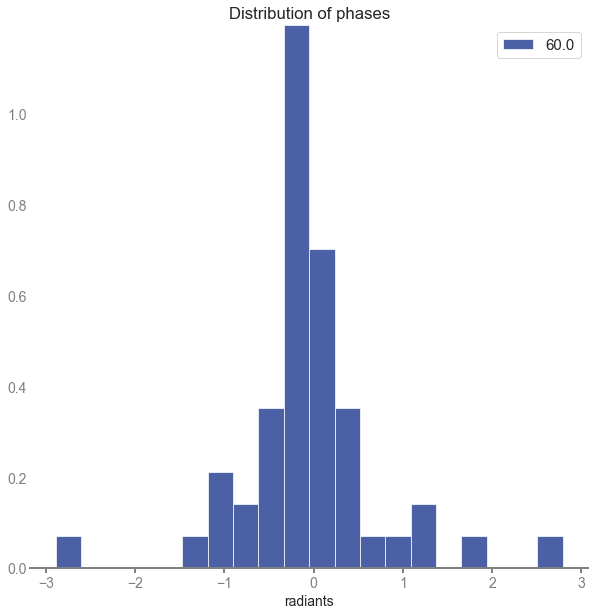

In [321]:
group = stacked_sales.get_group(40.0)
corr, eVal, eVec = complex_eigendecomposition(group)
ang_sum, magnitudes, phases = total_sum(eVec[:,0])
plt.hist(phases, bins=20, label=f'{sec}', density=True, alpha=0.7)
plt.title('Distribution of phases')
plt.legend()
plt.xlabel('radiants')

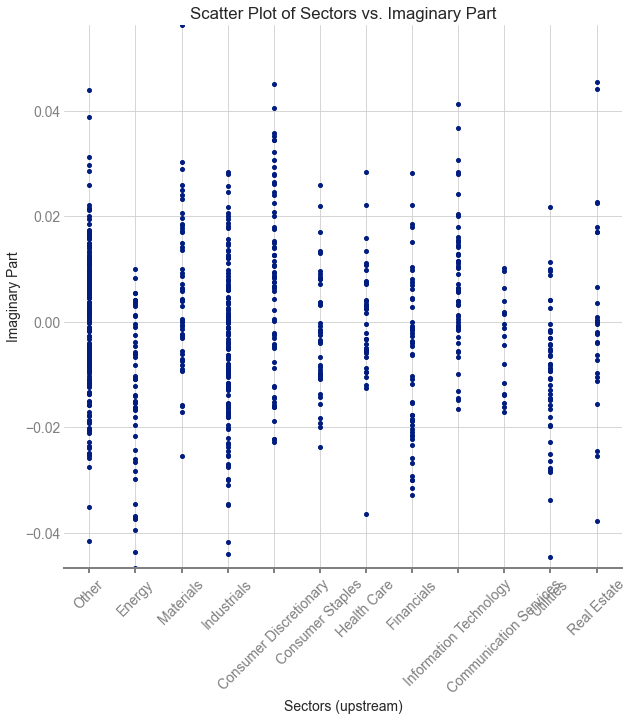

In [401]:
def plotting_sectors_phases(complex_array, sectors):
    # Define the desired order of sectors
    sector_order = ['Other', 'Energy', 'Materials', 'Industrials', 'Consumer Discretionary',
                    'Consumer Staples', 'Health Care', 'Financials', 'Information Technology',
                    'Communication Services', 'Utilities', 'Real Estate']
    
    # Extract the real and imaginary parts and modulus
    real_part = np.real(complex_array)
    imaginary_part = np.imag(complex_array)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Sort the sectors and corresponding imaginary parts based on the desired order
    sorted_indices = np.argsort([sector_order.index(s) for s in sectors])
    sorted_sectors = [sectors[i] for i in sorted_indices]
    sorted_imaginary_part = imaginary_part[sorted_indices]
    
    # Plot the sorted complex array
    ax.scatter(sorted_sectors, sorted_imaginary_part, marker='o')
    plt.xticks(rotation=45)  # Rotates x-axis tick labels by 45 degrees
    plt.grid(True)
    plt.xlabel('Sectors (upstream)')
    plt.ylabel('Imaginary Part')
    plt.title('Scatter Plot of Sectors vs. Imaginary Part')
    plt.show()
    
plotting_sectors_phases(eVec[:,0], key_sect)

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_22319/2547015040.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10')


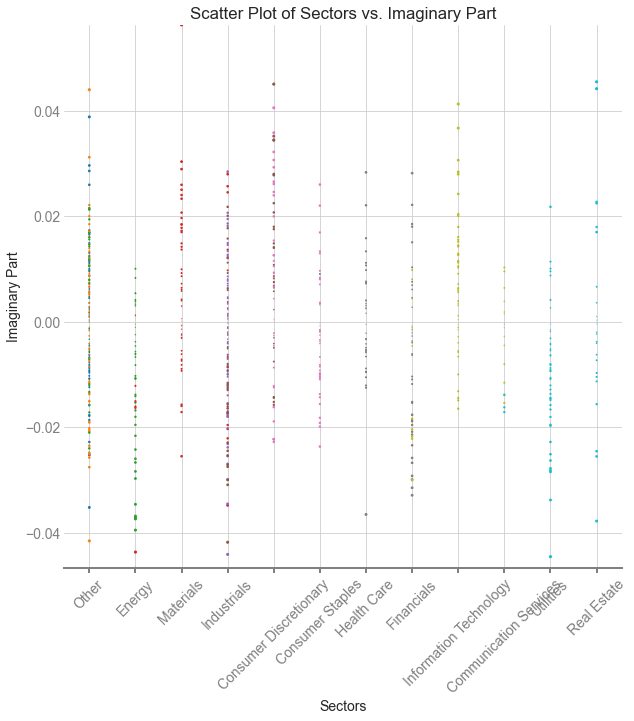

In [400]:
import matplotlib.cm as cm

def plotting_sectors_phases(complex_array, sectors):
    # Define the desired order of sectors
    sector_order = ['Other', 'Energy', 'Materials', 'Industrials', 'Consumer Discretionary',
                    'Consumer Staples', 'Health Care', 'Financials', 'Information Technology',
                    'Communication Services', 'Utilities', 'Real Estate']
    # ordered in a upstream fashion following the codes of CompuStat sectors
    # Extract the real and imaginary parts and modulus
    real_part = np.real(complex_array)
    imaginary_part = np.imag(complex_array)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Sort the sectors and corresponding imaginary parts based on the desired order
    sorted_indices = np.argsort([sector_order.index(s) for s in sectors])
    sorted_sectors = [sectors[i] for i in sorted_indices]
    sorted_imaginary_part = imaginary_part[sorted_indices]
    
    # Assign colors based on sectors using a colormap
    colors = cm.get_cmap('tab10')
    
    # Adjust marker sizes based on imaginary_part values
    sizes = np.abs(sorted_imaginary_part) * 100
    
    # Plot the sorted complex array with color-coded and size-adjusted markers
    sc = ax.scatter(sorted_sectors, sorted_imaginary_part, marker='o', c=range(len(sorted_sectors)),
                    cmap=colors, s=sizes)
    
    # Add a colorbar legend
    #cbar = plt.colorbar(sc, ticks=range(len(sorted_sectors)))
    #cbar.set_label('Sectors')

    
    # Plot the sorted complex array
    #ax.scatter(sorted_sectors, sorted_imaginary_part, marker='o')
    plt.xticks(rotation=45)  # Rotates x-axis tick labels by 45 degrees
    plt.grid(True)
    plt.xlabel('Sectors')
    plt.ylabel('Imaginary Part')
    plt.title('Scatter Plot of Sectors vs. Imaginary Part')
    plt.show()
    
plotting_sectors_phases(eVec[:,0], key_sect)

- principal modes

In [358]:
def coefficient_mode(eVec, data_matrix, mode = 0):
    coeff_mode = np.dot(eVec[:,mode], data_matrix.H)
    coeff_mode = np.array(coeff_mode, dtype=complex)[0]
    
    return coeff_mode

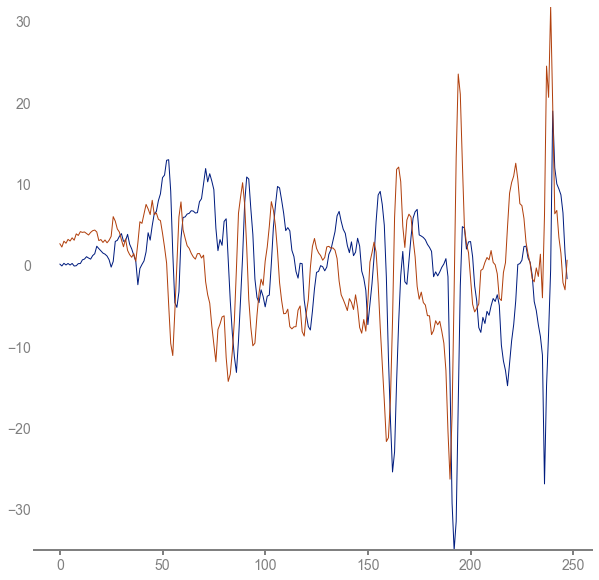

In [360]:
analytic_s = analytic_signal(sales)
corr, eVal, eVec = complex_eigendecomposition(analytic_s)

f_mode = coefficient_mode(eVec, analytic_s)
plt.plot(f_mode.real)
plt.plot(f_mode.imag)

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


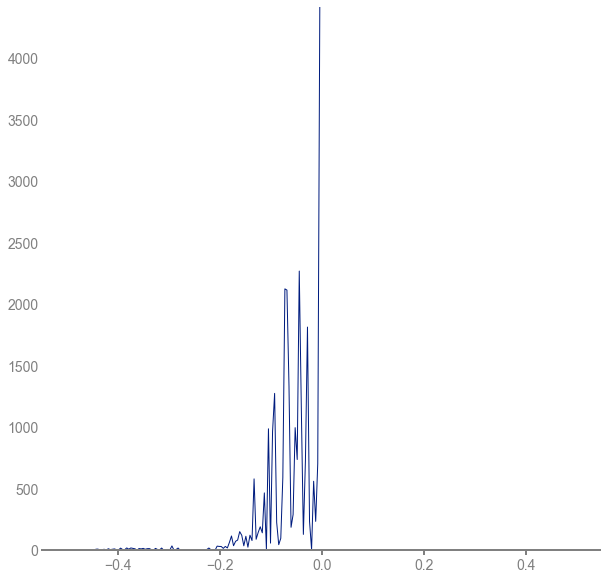

In [363]:
from scipy.signal import periodogram
fs, den = periodogram(f_mode)
plt.plot(fs, den)

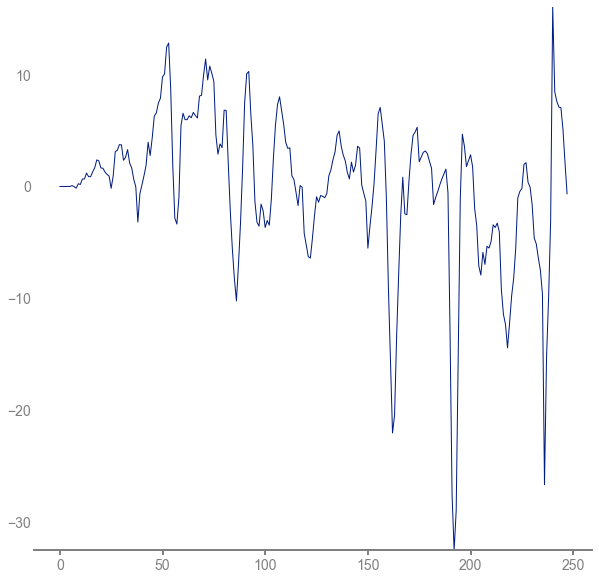

In [355]:
# find the top mode for real time series 
sales = analytic_s.real
sales = pd.DataFrame(sales)
c = sales.corr()
w,v = np.linalg.eigh(c)
top = v[:, -1]
top_mode = np.dot(sales, top)
plt.plot(top_mode)

In [364]:
f2, den2 = periodogram(top_mode)

(0.0, 0.4)

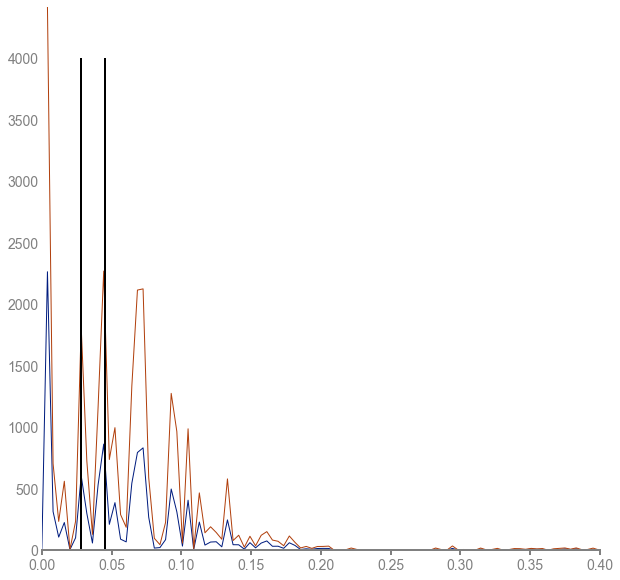

In [365]:
plt.plot(f2, den2)
plt.plot(-fs, den)
plt.vlines([0.028, 0.045], 0, 4000, lw=2, color='black')
plt.xlim(0, 0.4)

In [366]:
from scipy.fft import fft 
phases = np.angle(fft(top_mode))

(0.0, 0.4)

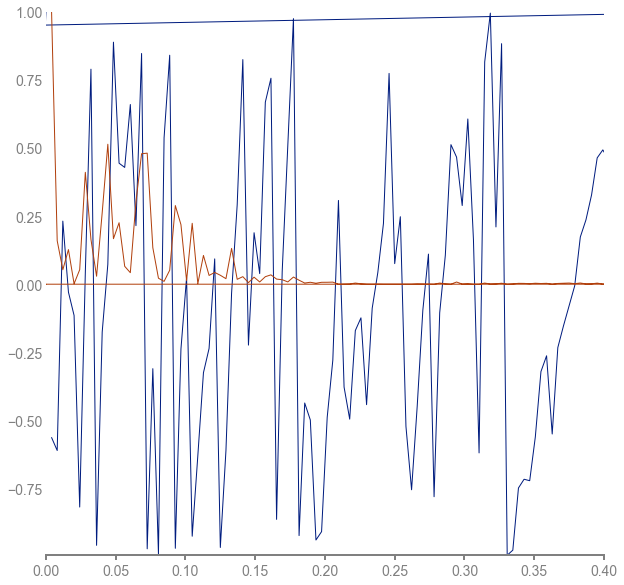

In [367]:
plt.plot(-fs, -phases/np.max(np.abs(phases)))
plt.plot(-fs, den/np.max(den))

plt.xlim(0, 0.4)

### Systematize the approach:
Using analytical toy-model 

- **Example 1:**


$s(t) = \cos(\omega t) $

<math>\begin{align}
\hat{s}(t) &= \cos\left(\omega t - \frac{\pi}{2}\right) = \sin(\omega t), \\
s_\mathrm{a}(t) &= s(t) + j\hat{s}(t) = \cos(\omega t) + j\sin(\omega t) = e^{j\omega t}
\end{align}</math>


$s(t) = \cos(\omega t + \theta) = \frac{1}{2} \left(e^{j (\omega t+\theta)} + e^{-j (\omega t+\theta)}\right)$


<math> $s_\mathrm{a}(t) =$ \begin{cases}
e^{j(\omega t + \theta)} \ \ = \ e^{j |\omega| t}\cdot e^{j\theta} , & \text{if} \ \omega  > 0, \\
e^{-j(\omega t + \theta)} = \ e^{j |\omega| t}\cdot e^{-j\theta} , & \text{if} \ \omega  < 0.
\end{cases}
</math>
    
To compute the correlation between two signals, we need to calculate the cross-correlation function. In this case, we have two signals:

$s_1(t) = e^{jwt}$


$s_2(t) = e^{j(wt + \theta)}$

the complex conjugate of $s_2$, denoted as $s_2^*$ is:

$s_2^*(t) = e^{-j(wt + \theta)}$


Now, we can compute the correlation by taking the expectation value of the product of $s_1$ and the complex conjugate of $s_2$, denoted as $s_2^*$.

$C_{1,2} = \langle s_1(t) s_2^*(t) \rangle$

To calculate this, we integrate the product of $s_1$ and $s_2^*$ over a period of time and average the result.

$= \frac{1}{T} \int_{0}^{T} s_1(t) s_2^*(t) dt$


$= \frac{1}{T} \int_{0}^{T} e^{jwt} e^{-j(wt + \theta)} dt$

Since $e^{j\theta} e^{-j\theta} = 1$, 

$= \frac{1}{T} \int_{0}^{T} e^{jwt - jwt - j\theta} dt$


$= \frac{1}{T} \left[ e^{-j\theta} t \right]_{0}^{T}$


$= \frac{1}{T} \left( e^{-j\theta} T - e^{-j\theta} 0 \right)$


$= e^{-j\theta}$


Similarly, we can compute the correlation for $s_1 s_1$ and $s_2 s_2$ by substituting the appropriate expressions:

The correlation matrix for $s_1$ and $s_2$ is given by:

$\mathbf{C} = 
\begin{bmatrix}
1 & e^{-j\theta} \\
e^{+j\theta} & 1
\end{bmatrix}$

To find the eigenvectors and eigenvalues, we solve the equation:

$
(\mathbf{C} - \lambda\mathbf{I})\mathbf{x} = 0
$

where $\mathbf{C}$ is the correlation matrix, $\lambda$ is the eigenvalue, $\mathbf{I}$ is the identity matrix, and $\mathbf{x}$ is the eigenvector.

First, let's find the eigenvalues:

$
|\mathbf{C} - \lambda\mathbf{I}| = 
\begin{vmatrix}
1-\lambda & e^{-j\theta} \\
e^{j\theta} & 1-\lambda
\end{vmatrix}
$

Expanding the determinant, we get:

$
(1 - \lambda)(1 - \lambda) - e^{j\theta}e^{-j\theta} = 0
$

Simplifying, we find two possible eigenvalues:
1) $\lambda_1 = 2$

2) $\lambda_2 = 0$

Next, let's find the eigenvectors associated with each eigenvalue.

1) For $\lambda_1 = 2$:

$
(\mathbf{C} - 2\mathbf{I})\mathbf{x} = 0
$

$
\begin{bmatrix}
-1 & e^{-j\theta} \\
e^{j\theta} & -1
\end{bmatrix}
\mathbf{x} = 0
$

From the first equation, we can express $x_2$ in terms of $x_1$:

$
x_2 = e^{-j\theta}x_1
$

Substituting this into the second equation, we have:

$
e^{j\theta}x_1 - x_1 = 0
$

So the eigenvector for $\lambda_1 = 2$ is:

$
\mathbf{x}_1 = \begin{bmatrix} x_1 \\ e^{-j\theta}x_1 \end{bmatrix} \text{, where } x_1 \neq 0 \text{ and } e^{j\theta} \neq 1
$

2) For $\lambda_2 = 0$:

$
(\mathbf{C} - 0\mathbf{I})\mathbf{x} = 0
$

$
\begin{bmatrix}
1 & e^{-j\theta} \\
e^{j\theta} & 1
\end{bmatrix}
\mathbf{x} = 0
$

From the first equation, we can express $x_2$ in terms of $x_1$:

$
x_2 = -e^{-j\theta}x_1
$

Substituting this into the second equation, we have:

$
e^{j\theta}x_1 + x_1 = 0
$

So the eigenvector for $\lambda_2 = 0$ is:

$
\mathbf{x}_2 = \begin{bmatrix} x_1 \\ -e^{-j\theta}x_1 \end{bmatrix} \text{, where } x_1 \neq 0 \text{ and } e^{j\theta} \neq -1
$


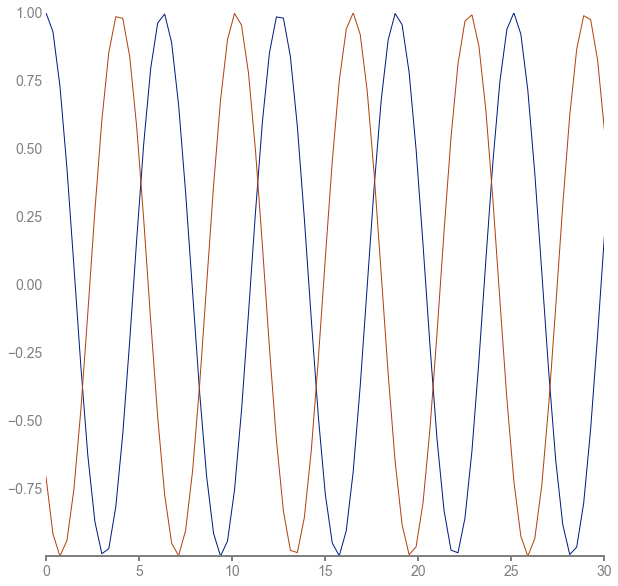

In [176]:
x = np.linspace(0,300, num = 800)
θ = np.pi*(3/4)
series1 = np.cos(x)
series2 = np.cos(x + θ)
an_series = np.column_stack((series1, series2))

plt.plot(x, series1)
plt.plot(x, series2)
plt.xlim(0,30)
plt.show()

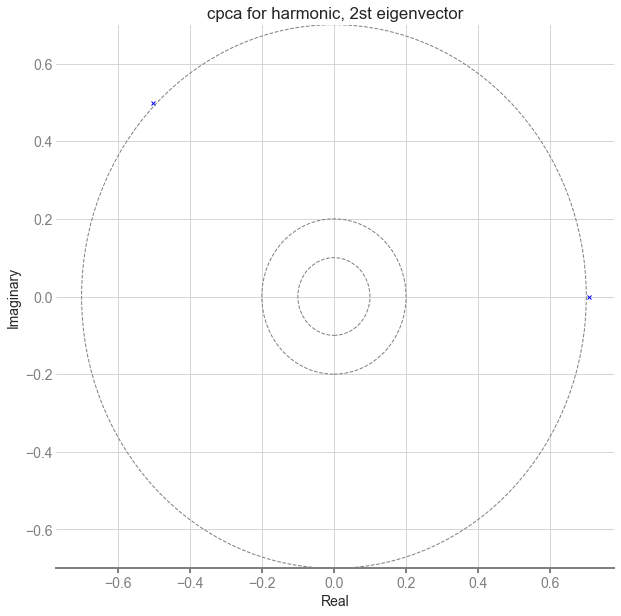

In [182]:
analytic = analytic_signal(an_series)
corr, eVal, eVec = complex_eigendecomposition(analytic)
plotting_complex_plane(eVec[:, 1], title = "cpca for harmonic, 2st eigenvector", rad3=0.7)

Text(0.5, 0, 'radiants')

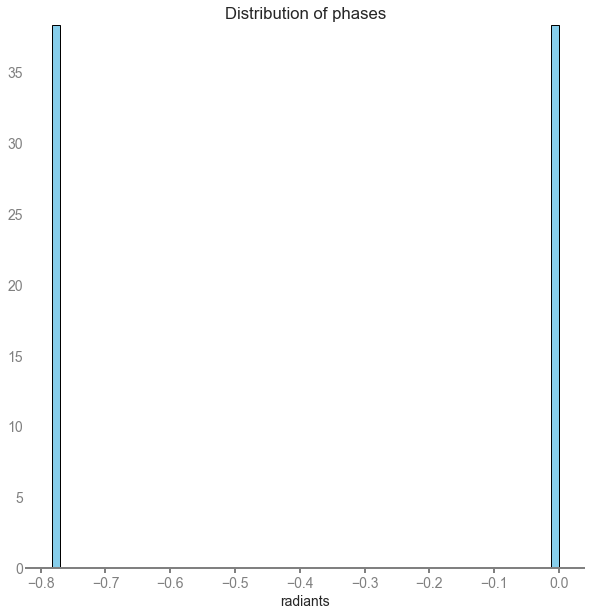

In [180]:
ang_sum, magnitudes, phases = total_sum(eVec[:,0])
plt.hist(phases, bins=60, color='skyblue', edgecolor='black', density=True)
plt.title('Distribution of phases')
plt.xlabel('radiants')

In [181]:
print("with a lag of {0} radiants between the two harmonic functions, I find that the phases for the second eVec are {1}".format(θ, phases))

with a lag of 2.356194490192345 radiants between the two harmonic functions, I find that the phases for the second eVec are [0.0, -0.7830568705569808]


- **Example 2:**


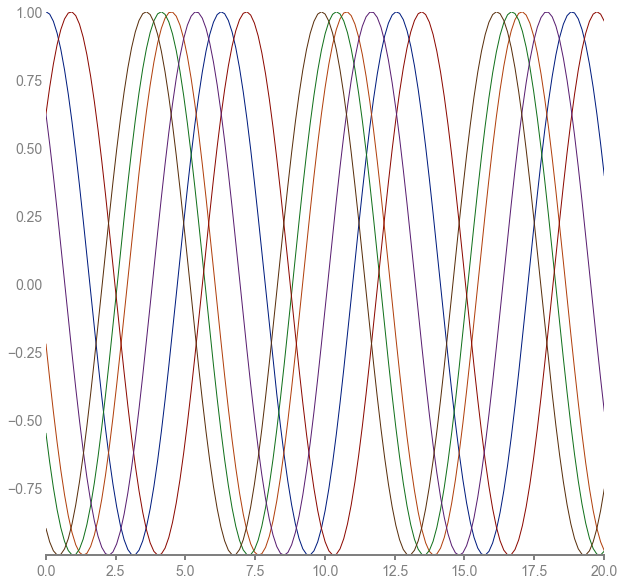

In [156]:
x = np.linspace(0,200, num = 1500)
θ = np.pi*(4/7)
series1 = np.cos(x)
series2 = np.cos(x + θ)
series3 = np.cos(x + 1.2*θ)
series4 = np.cos(x + 3*θ)
series5 = np.cos(x + 4*θ)
series6 = np.cos(x + 5*θ)
series7 = np.cos(x + 6*θ)
series8 = np.cos(x + 7*θ)
an_series = np.column_stack((series1, series2, series3, series4, series5, series6, series7))

plt.plot(x, series1)
plt.plot(x, series2)
plt.plot(x, series3)
plt.plot(x, series4)
plt.plot(x, series5)
plt.plot(x, series6)
plt.xlim(0,20)
plt.show()

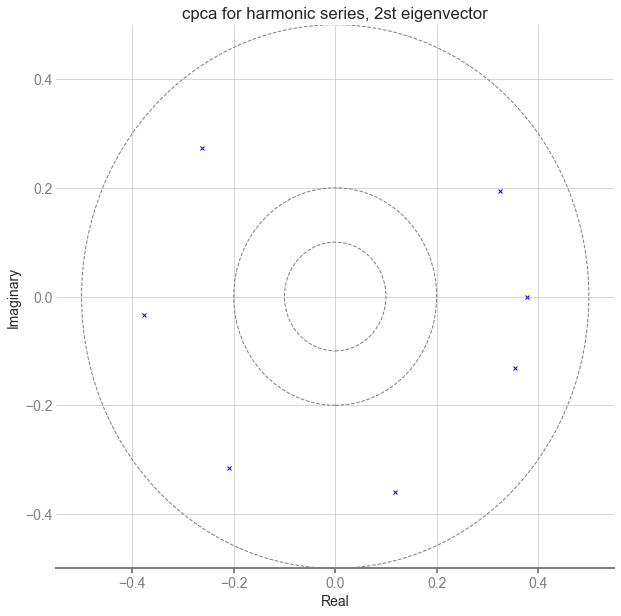

In [157]:
analytic = analytic_signal(an_series)
corr, eVal, eVec = complex_eigendecomposition(analytic)
plotting_complex_plane(eVec[:, 0], title = "cpca for harmonic series, 2st eigenvector", rad3=0.5)

Text(0.5, 0, 'radiants')

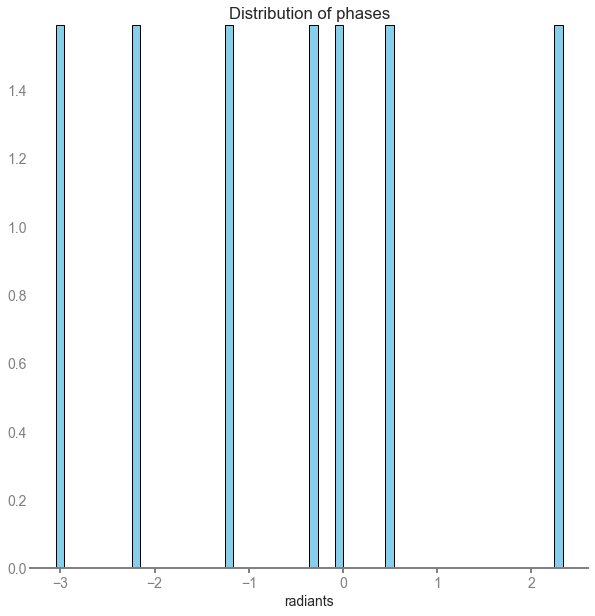

In [169]:
ang_sum, magnitudes, phases = total_sum(eVec[:,0])
plt.hist(phases, bins=60, color='skyblue', edgecolor='black', density=True)
plt.title('Distribution of phases')
plt.xlabel('radiants')

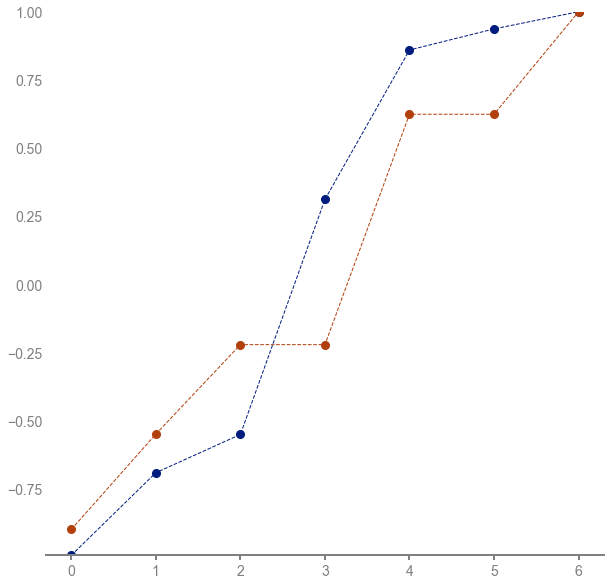

In [170]:
plt.plot(np.sort(np.cos(phases)), linestyle='--', marker ='o', markersize=8)
plt.plot(np.sort(np.cos([θ, 1.2*θ, 3*θ, 4*θ, 5*θ, 6*θ, 7*θ])), linestyle='--', marker ='o', markersize=8)

- **Example 3: White Noise**


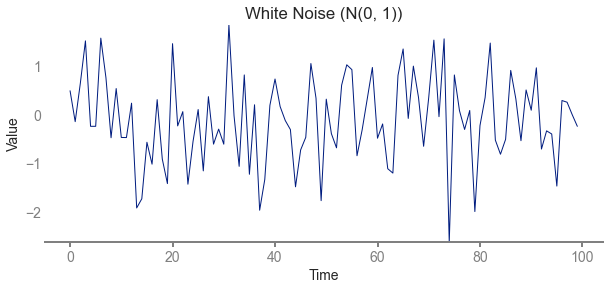

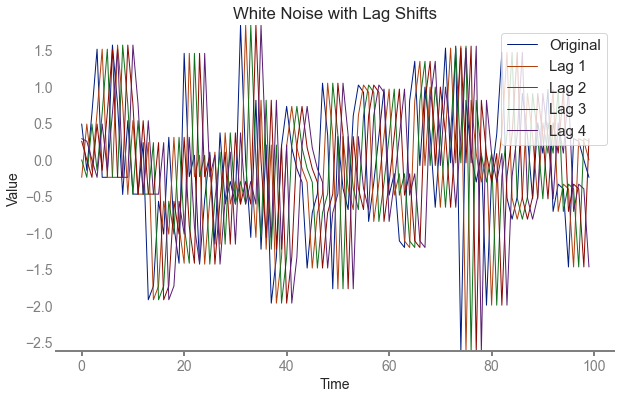

In [26]:
# Set the seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 100

# Generate white noise series N(0, 1)
white_noise = np.random.normal(0, 1, num_points)

# Plot the white noise series
plt.figure(figsize=(10, 4))
plt.plot(white_noise)
plt.title('White Noise (N(0, 1))')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Define lag values
lags = [1, 2, 3, 4]

# Generate shifted time series
shifted_series = []
for lag in lags:
    shifted_series.append(np.roll(white_noise, lag))

# Plot the shifted time series
plt.figure(figsize=(10, 6))
plt.plot(white_noise, label='Original')
for i, series in enumerate(shifted_series):
    plt.plot(series, label=f'Lag {lags[i]}')
plt.title('White Noise with Lag Shifts')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


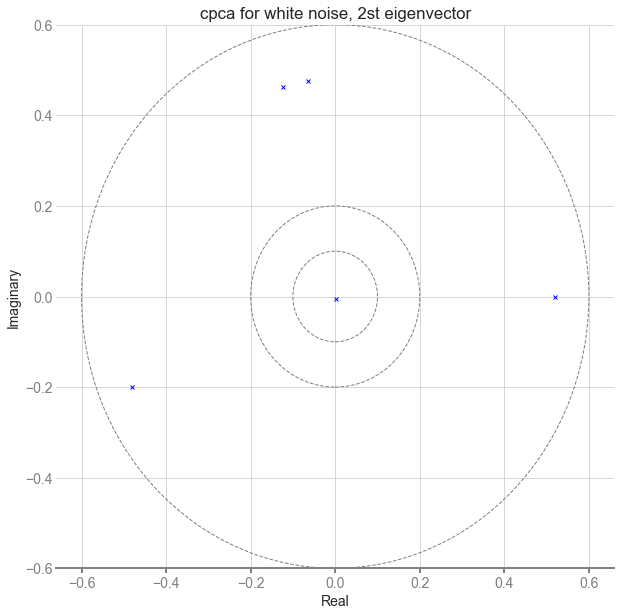

In [28]:
an_series = np.column_stack((white_noise, shifted_series[0], shifted_series[1], shifted_series[2], shifted_series[3]))
analytic = analytic_signal(an_series)
corr, eVal, eVec = complex_eigendecomposition(analytic)
plotting_complex_plane(eVec[:,0], title = "cpca for white noise, 2st eigenvector", rad3=0.6)